**Chapter_2e**  
**ATMOS 5040: Environmental Statistics**  
**John Horel **

Download this notebook and all images and data by downloading the ZIP file from GitHub, or use the git command:

    git clone https://github.com/johnhorel/ATMOS_5040_2019.git
    
> Note: Windows users will have to install [git for Windows](https://gitforwindows.org/) and execute the git command from the PowerShell.

# Using Python modules

`numpy` provides routines to handle arrays and many calculations efficiently and imported by convention as `np`. Numpy functions are very good at handling homogeneous data arrays (and similar in that respect to matlab functions).

`pandas` is really good at handling tabular/array data that may have heterogeneous types (floating and text, for example). It is imported by convention as `pd`. 

There are a couple sets of panda library routines  (`Series`, and `DataFrame`) used so frequently that we'll import those directly too.

`scipy` has a bunch of statistical functions and we'll import `stats` from `scipy`



`pyplot` is a _submodule_ of matplotlib. It is typically imported as the alias `plt` to handle basic plotting

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime

# Chapter 2e

get time series of wind speed and direction from WBB for June 2018 in csv format
documentation on how that was done from Synoptic api services
http://synopticdata.com
http://api.synopticlabs.org/v2/stations/timeseries?stid=wbb&output=csv&obtimezone=local&start=201806010600&end=201807010559&vars=wind_speed,wind_direction,wind_gust&obtimezone=local&timeformat=%y%m%d%H%M&token=tk2019jan0216yZVw1gWKP6oIdgvChuT
requires an active token to run the above
returns a csv file with a header and text line that have been removed
4 columns: date(YYMMDDHHMM), wind speed (m/s) direction, wind gust(m/s)

Another decent resource on pandas
https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/

In [3]:
#need to parse the date string
dateparse = lambda x: pd.datetime.strptime(x, '%y%m%d%H%M')
#there are times with no actual values (direction blank and wind speed and gust 0)
#those will get changed to NaN by the read_csv function
headers = ['Date', 'Speed', 'Direction', 'Gust']
dtypes = {'Date': 'str', 'Speed': 'float', 'Direction': 'float', 'Gust': 'float'}
df = pd.read_csv('data/wbb_wind_0618.csv', parse_dates=['Date'], date_parser=dateparse, \
                 names=headers,dtype = dtypes,na_filter=True)
#print(df)

In [4]:
#some basic info + output precentiles
basic_vals = df.describe(percentiles=[.01,.10,.25,.33,.50,.66,.75,.90,.99])
print(basic_vals)
#note that there are "missing" blank wind directions and those values have 0 wind speed and gust
#so the counts of direction are lower than for speed. it is critical to remove those rows
#remove rows with a NaN in any column
df=df.dropna()
basic_vals = df.describe(percentiles=[.01,.10,.25,.33,.50,.66,.75,.90,.99])
print(basic_vals)
#now the number of rows is the same

              Speed     Direction          Gust
count  43140.000000  42677.000000  43140.000000
mean       3.040631    179.597099      4.212415
std        1.929088    118.017454      2.661474
min        0.000000      0.010000      0.000000
1%         0.000000      2.142800      0.000000
10%        0.810000     28.720000      1.280000
25%        1.590000     59.080000      2.227500
33%        1.950000     84.400000      2.640000
50%        2.750000    181.400000      3.720000
66%        3.620000    268.300000      4.900000
75%        4.190000    294.800000      5.680000
90%        5.600000    332.100000      7.840000
99%        8.780000    357.000000     12.540000
max       14.340000    360.000000     19.300000
              Speed     Direction          Gust
count  42677.000000  42677.000000  42677.000000
mean       3.073619    179.597099      4.258045
std        1.913207    118.017454      2.639372
min        0.010000      0.010000      0.100000
1%         0.090000      2.142800      0

# Figure 2.12 Statistics on Wind Speed and Direction


42677


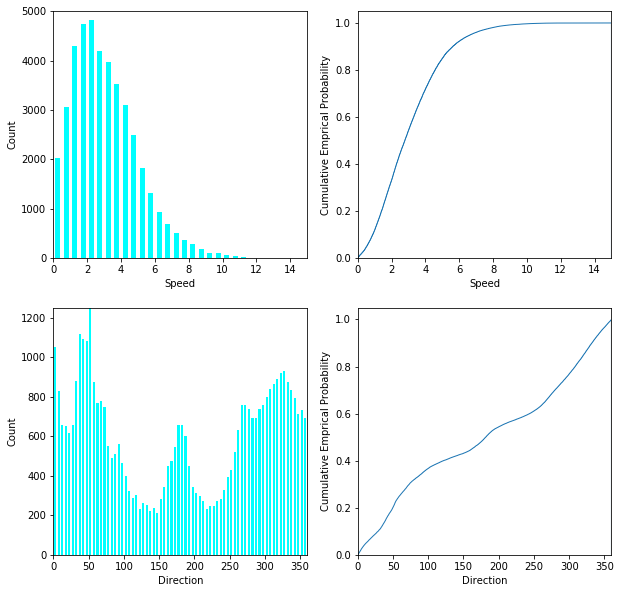

In [5]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
x1 = np.arange(0.,15.5,.5)
hist_val1,bins1 = np.histogram(df['Speed'].values,bins=x1,range=(x1.min(),x1.max()))
width1 = 0.6 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2
ax1 = ax[0,0]
ax1.bar(center1,hist_val1,align='center',width=width1,color='cyan')
ax1.set(xlim=(0,15),ylim=(0,5000))
ax1.set(xlabel="Speed",ylabel='Count')

x2 = np.arange(0,365,5)
hist_val2,bins2 = np.histogram(df['Direction'].values,bins=x2,range=(x2.min(),x2.max()))
width2 = 0.6 * (bins2[1] - bins2[0])
center2 = (bins2[:-1] + bins2[1:]) / 2
ax2 = ax[1,0]
ax2.bar(center2,hist_val2,align='center',width=width2,color='cyan')
ax2.set(xlim=(0,360),ylim=(0,1250))
ax2.set(xlabel="Direction",ylabel='Count')


#get total number of values
shape = df.shape
n_bins = shape[0]
print(n_bins)
ax3 = ax[0,1]
n, bins, patches = ax3.hist(df['Speed'].values, n_bins, density='True', histtype='step', \
                           cumulative=True, label='Empirical', range=(x1.min(),x1.max()))

ax3.set(xlabel="Speed",ylabel='Cumulative Emprical Probability')
ax3.set(xlim=(x1.min(),x1.max()))

ax4 = ax[1,1]
n, bins, patches = ax4.hist(df['Direction'].values, n_bins, density='True', histtype='step', \
                           cumulative=True, label='Empirical', range=(x2.min(),x2.max()))

ax4.set(xlabel="Direction",ylabel='Cumulative Emprical Probability')
ax4.set(xlim=(x2.min(),x2.max()))
plt.savefig('figure_2.12_2019_python.png')

In [6]:
#convert spd,dir to u,v. python- 0 angle is relative to x axis and then counterclockwise
pid = np.pi/180.
u = df['Speed'] * np.sin(pid*(df['Direction'] - 180));
v = df['Speed'] * np.cos(pid*(df['Direction'] - 180));
#add to dataframe the zonal and meridional values
df['u']= u.values
df['v']= v.values
#print(u)
#note that u and v computed for times when no missing data
basic_vals = df.describe(percentiles=[.01,.10,.25,.33,.50,.66,.75,.90,.99])
print(basic_vals)

              Speed     Direction          Gust             u             v
count  42677.000000  42677.000000  42677.000000  42677.000000  42677.000000
mean       3.073619    179.597099      4.258045      0.098468     -0.630564
std        1.913207    118.017454      2.639372      2.251164      2.762727
min        0.010000      0.010000      0.100000     -8.007969    -12.635018
1%         0.090000      2.142800      0.390000     -4.686675     -6.405586
10%        0.880000     28.720000      1.370000     -2.799126     -3.671036
25%        1.630000     59.080000      2.250000     -1.506270     -2.208461
33%        1.990000     84.400000      2.640000     -0.909704     -1.748787
50%        2.780000    181.400000      3.720000      0.013718     -0.822926
66%        3.640000    268.300000      4.900000      0.929408     -0.057803
75%        4.200000    294.800000      5.780000      1.549235      0.379706
90%        5.610000    332.100000      7.840000      3.156119      2.694388
99%        8

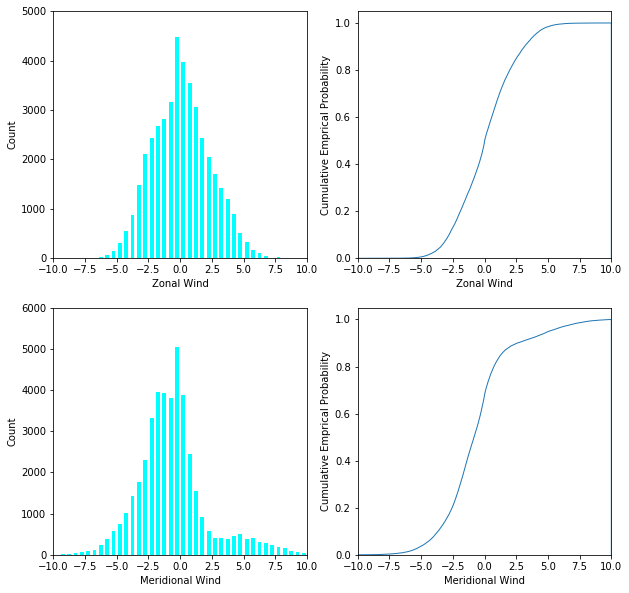

In [7]:
#plotting zonal and meridional wind statistics
fig,ax = plt.subplots(2,2,figsize=(10,10))
x1 = np.arange(-10.,10.5,.5)
hist_val1,bins1 = np.histogram(u.values,bins=x1,range=(x1.min(),x1.max()))
width1 = 0.6 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2
ax1 = ax[0,0]
ax1.bar(center1,hist_val1,align='center',width=width1,color='cyan')
ax1.set(xlim=(-10,10),ylim=(0,5000))
ax1.set(xlabel="Zonal Wind",ylabel='Count')

x2 = np.arange(-10,10.5,.5)
hist_val2,bins2 = np.histogram(v.values,bins=x2,range=(x2.min(),x2.max()))
width2 = 0.6 * (bins2[1] - bins2[0])
center2 = (bins2[:-1] + bins2[1:]) / 2
ax2 = ax[1,0]
ax2.bar(center2,hist_val2,align='center',width=width2,color='cyan')
ax2.set(xlim=(-10,10),ylim=(0,6000))
ax2.set(xlabel="Meridional Wind",ylabel='Count')

ax3 = ax[0,1]
n, bins, patches = ax3.hist(u.values, n_bins, density='True', histtype='step', \
                           cumulative=True, label='Empirical', range=(x1.min(),x1.max()))

ax3.set(xlabel="Zonal Wind",ylabel='Cumulative Emprical Probability')
ax3.set(xlim=(x1.min(),x1.max()))

ax4 = ax[1,1]
n, bins, patches = ax4.hist(v.values, n_bins, density='True', histtype='step', \
                           cumulative=True, label='Empirical', range=(x2.min(),x2.max()))

ax4.set(xlabel="Meridional Wind",ylabel='Cumulative Emprical Probability')
ax4.set(xlim=(x2.min(),x2.max()))
plt.savefig('figure_2.13_2019_python.png')

In [8]:
#some other statistics
#switch Dataframe to array
winda = df[['Speed','Direction','Gust','u','v']].values
#print(winda)
modes = stats.mode(winda,axis=0)
print(modes)

# unbiased estimate of pop standard deviation and variance
std0 = np.std(winda,ddof=1,axis=0)
var0 = np.var(winda,ddof=1,axis=0)
print('pop standard deviation and variance',std0,var0)
# sample standard deviation and variance
std1 = np.std(winda,axis=0)
var1 = np.var(winda,axis=0)
print('pop standard deviation and variance',std1,var1)
#skewness
skew = stats.skew(winda,axis=0)
print('skewness',skew)



ModeResult(mode=array([[ 2.11000000e+00,  3.18200000e+02,  1.96000000e+00,
         0.00000000e+00, -9.95396198e-03]]), count=array([[138,  33, 819,  11,   4]]))
pop standard deviation and variance [  1.91320668 118.01745409   2.63937218   2.25116376   2.76272694] [3.66035980e+00 1.39281195e+04 6.96628552e+00 5.06773825e+00
 7.63266015e+00]
pop standard deviation and variance [  1.91318427 118.0160714    2.63934126   2.25113738   2.76269457] [3.66027403e+00 1.39277931e+04 6.96612228e+00 5.06761951e+00
 7.63248130e+00]
skewness [ 0.89746134 -0.01489605  1.04693981  0.16815614  0.89203443]


# Wind Rose

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: bool 
  backgroundcolor: any matplotlib color 
  bbox: FancyBboxPatch prop dict 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: bool 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color: any matplotlib color 
  contains: a callable function 
  family or fontfamily or fontname or name: [FONTNAME | 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace' ] 
  figure: a `.Figure` instance 
  fontproperties or font_properties: a :class:`matplotlib.font_manager.FontProperties` instance 
  gid: an id string 
  horizontalalignment or ha: [ 'center' | 'right' | 'left' ] 
  label: object 
  linespacing: float (multiple of font size) 
  multialignment or ma: ['left' | 'right' | 'center' ] 
  path_

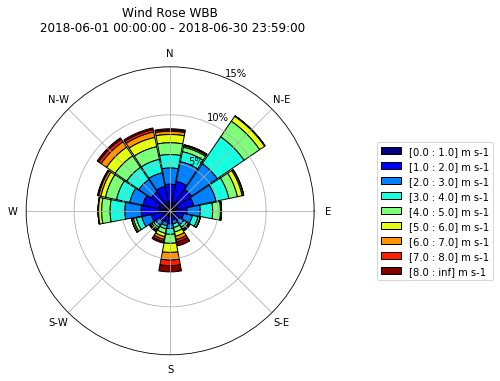

In [9]:
# use code created by Brian Blaylock that was adapted from other open source windrose code
from windrose import WindroseAxes

#get first and last dates for label
firsttime = df.Date.iloc[0]
lasttime = df.Date.iloc[-1]
#print(firsttime,lasttime)


fig = plt.figure(figsize=(5, 10), facecolor='w', edgecolor='w')
rect = [0.1, 0.1, 0.8, 0.8]
#the critical part to get polar coordinate
ax = WindroseAxes(fig, rect)
fig.add_axes(ax)

#wind direction is "x" and wind speed is "y"
ax.bar(winda[:,1], winda[:,0],
           bins=[0, 1, 2, 3, 4, 5, 6, 7, 8],
           nsector=16,
           normed=True,
           opening=.95,
           edgecolor='k')
#the above causes some warning diagnostics that I will ignore!
l = ax.legend()
plt.setp(l.get_texts())
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), prop={'size':10})
plt.title("Wind Rose WBB\n %s - %s\n" % (firsttime,lasttime))
plt.grid(True)
plt.yticks(np.arange(0, 105, 5))
ax.set_yticklabels(['', '5%', '10%', '15%', '20%', '25%', '30%', '', '40%'])
ax.set_rmax(15)
plt.savefig("figure_2.14_python.png")

# Resultant vs Mean Wind



% compute resultant wind speed for each hour
ressp = sqrt(um.*um+vm.*vm);
hrlbl = 0:1:23;
figure(15)
hold on
plot(hrlbl,spm,'r')
plot(hrlbl,ressp,'g')
axis([0 23 0 5])
xlabel('Hour of day');
ylabel('Wind Speed (m/s)');
title('WBB Mean and Resultant Wind Speed: John Horel 12/26/2018');


In [10]:
#one of the nice features of pandas. group in this case by time of day
diurnal_wind=df.groupby([df["Date"].dt.hour]).mean()
print(diurnal_wind)
ds=diurnal_wind['Speed'].values
du=diurnal_wind['u'].values
dv=diurnal_wind['v'].values
#compute resultant wind speed for each hour
ressp = np.sqrt(du*du+dv*dv)
print(ds,ressp)

         Speed   Direction      Gust         u         v
Date                                                    
0     2.733414  111.615845  3.499429 -1.606556 -0.204297
1     2.694406  100.664451  3.491234 -1.434194 -0.759567
2     2.687908   94.538587  3.481032 -1.534257 -0.773662
3     2.241185  120.456405  2.915386 -0.989598 -0.618137
4     2.484980  125.120287  3.277059 -0.815251 -0.979676
5     2.263299  119.638906  2.959915 -0.620671 -0.943947
6     1.939687  130.296133  2.531458 -0.773753 -0.557098
7     1.556176  159.402131  2.088651 -0.356769 -0.376374
8     1.409553  210.655636  2.083290  0.334159  0.025933
9     2.040807  245.994749  3.084521  0.905554  0.051658
10    2.710217  242.183356  4.107674  1.201665  0.703596
11    3.100511  232.117504  4.692229  1.283735  0.681943
12    3.586934  244.146797  5.395977  1.721840  0.482048
13    3.946444  247.998880  5.888757  1.746635  0.104158
14    4.169567  257.225350  6.142294  2.028662 -0.140035
15    4.389011  256.814222  6.3

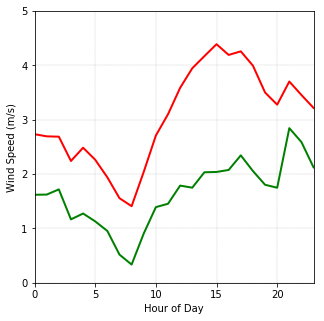

In [11]:
#plot mean wind speed vs resultant wind speed
fig15,ax = plt.subplots(1,1,figsize=(5,5),facecolor='w', edgecolor='w')
xd = np.arange(0,24)
ax.plot(xd,ds,color='red',linewidth=2);
ax.plot(xd,ressp,color='green',linewidth=2);
ax.set(xlim=(0,23),ylim=(0,5))
ax.set(xlabel="Hour of Day",ylabel='Wind Speed (m/s)')
ax.grid(linestyle='--', color='grey', linewidth=.2)
plt.savefig('figure_2.15_2019_python.png')